# Predicción de precios de computadores usando _scikit-learn_

Este cuaderno tiene como objetivo la implementación de un algoritmo de aprendizaje de máquinas para la predicción de precios de computadores basada en diversas características.

Se probarán varios modelos y al final se utilizará el que obtenga una mayor puntuación para la tarea de predicción.

Los datos a utilizar son descargados desde https://www.kaggle.com/muhammetvarl/laptop-price.

## 1. Primera inspección de los datos
Hagamos primero una somera inspección de los datos tal y como estos se obtienen desde el enlace de descarga. Para esto se usa la librería `pandas`.

In [1]:
import pandas as pd

datos = pd.read_csv("datos/laptop_price.csv")

datos.head()

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60


Como primer paso y antes de hacer un análisis exploratorio de estos datos, es necesario transformar varias columnas para extraer datos relevantes y almacenarlos en columnas dedicadas.

El modelo de aprendizaje de máquinas a implementar deberá predecir con cierto margen de error el valor `Price_euros` basado en las características de un computador, estas características estarán representadas por las columnas.

Los tipos de datos que almacena cada columna y la presencia de valores ausentes saberse al ejecutar

In [2]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   laptop_ID         1303 non-null   int64  
 1   Company           1303 non-null   object 
 2   Product           1303 non-null   object 
 3   TypeName          1303 non-null   object 
 4   Inches            1303 non-null   float64
 5   ScreenResolution  1303 non-null   object 
 6   Cpu               1303 non-null   object 
 7   Ram               1303 non-null   object 
 8   Memory            1303 non-null   object 
 9   Gpu               1303 non-null   object 
 10  OpSys             1303 non-null   object 
 11  Weight            1303 non-null   object 
 12  Price_euros       1303 non-null   float64
dtypes: float64(2), int64(1), object(10)
memory usage: 132.5+ KB


Con esto sabemos que las columnas `Inches` y `Price_euros` son de tipo numérico y que ninguna columna posee valores ausentes. Por lo tanto, nuestra siguiente tarea consiste en extraer información de las demás columnas.

## 2. Limpieza y modificación de columnas

Son varias las columnas que necesitan ciertas modificaciones preliminares. Como primer paso, se eliminan las columnas `laptop_ID` y `Product` pues estas no son necesarias para nuestros propósitos.

In [3]:
datos.drop("laptop_ID", axis=1, inplace=True)
datos.drop("Product", axis=1, inplace=True)

Las columnas `Company`, `Product` y `TypeName` pueden dejarse como están, en un análisis posterior se estudiará si removerlas o no mejora la puntuación de nuestro modelo.

La columna `ScreenResolution` posee información que se comunmente tiene un impacto considerable en el valor de un computador, como es la resolución de la pantalla y características como _full HD_, vamos a extraer estos datos.

Veamos qué tipo de características podemos encontrar en esta columna.

In [4]:
datos["ScreenResolution"][0:40]

0            IPS Panel Retina Display 2560x1600
1                                      1440x900
2                             Full HD 1920x1080
3            IPS Panel Retina Display 2880x1800
4            IPS Panel Retina Display 2560x1600
5                                      1366x768
6            IPS Panel Retina Display 2880x1800
7                                      1440x900
8                             Full HD 1920x1080
9                   IPS Panel Full HD 1920x1080
10                                     1366x768
11                            Full HD 1920x1080
12           IPS Panel Retina Display 2880x1800
13                            Full HD 1920x1080
14           IPS Panel Retina Display 2304x1440
15           IPS Panel Retina Display 2560x1600
16                            Full HD 1920x1080
17           IPS Panel Retina Display 2880x1800
18                            Full HD 1920x1080
19    IPS Panel Full HD / Touchscreen 1920x1080
20                                     1

Vemos que cada entrada posee la resolución de la pantalla, como 1366x768 por ejemplo, además de características como _Full HD_, _Retina Display_ o _IPS_, vamos entonces a extraer estas características y almacenar cada una en una columna. 

Se creará una columna `resolution` que almacenará únicamente la resolución de la pantalla y se creará una columna por cada característica relevante como _Full HD_ que en cada fila tendrá un valor de 1 si el computador correspondiente posee esa característica o 0 si el computador no la posee.

In [5]:
import numpy as np
import re

# Extrae la resolución de la pantalla del computador, por ejemplo 1366x768
def resolucion_pantalla(texto):
    match = re.search("[0-9]+x[0-9]+", texto, flags=re.IGNORECASE)
    if match is None:
        return np.nan
    else:
        return match[0]
        
# Extra características de la pantalla de un computador como full HD o 4K
def caract_pantalla(texto, patron):
    match = re.search(patron, texto, flags=re.IGNORECASE)
    if match is None:
        return 0
    else:
        return 1
        
datos["resolution"] = datos["ScreenResolution"].apply(resolucion_pantalla)

datos["touchscreen"] = datos["ScreenResolution"].apply(caract_pantalla, args=("Touchscreen",))

datos["full_hd"] = datos["ScreenResolution"].apply(caract_pantalla, args=("Full HD",))

datos["ips"] = datos["ScreenResolution"].apply(caract_pantalla, args=("IPS",))

datos["quad_hd"] = datos["ScreenResolution"].apply(caract_pantalla, args=("Quad HD",))

datos["ultra_hd"] = datos["ScreenResolution"].apply(caract_pantalla, args=("4K",))

datos["retina_display"] = datos["ScreenResolution"].apply(caract_pantalla, args=("Retina Display",))

datos.drop("ScreenResolution", axis=1, inplace=True)

Ahora los datos lucen así

In [6]:
datos.head()

,Company,TypeName,Inches,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros,resolution,touchscreen,full_hd,ips,quad_hd,ultra_hd,retina_display
0,Apple,Ultrabook,13.3,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69,2560x1600,0,0,1,0,0,1
1,Apple,Ultrabook,13.3,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94,1440x900,0,0,0,0,0,0
2,HP,Notebook,15.6,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00,1920x1080,0,1,0,0,0,0
3,Apple,Ultrabook,15.4,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45,2880x1800,0,0,1,0,0,1
4,Apple,Ultrabook,13.3,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60,2560x1600,0,0,1,0,0,1


La columna `Cpu` almacena información importante pues el cpu de un computador influye bastante en su precio, sin embargo, vamos a extraer la frecuencia del reloj de cada cpu (dada en GHz) y el fabricante. Es importante tener en cuenta que la frecuencia del reloj no es suficiente para medir la potencia.

In [7]:
def velocidad_reloj(texto):
    match = re.search("[0-9]\d*(?:\.\d+)?\s*GHz", texto, flags=re.IGNORECASE)
    if match is None:
        return np.nan
    else:
        value = re.search("[0-9]\d*(\.\d+)?", match[0])
        return float(value[0])

datos["frec_reloj"] = datos["Cpu"].apply(velocidad_reloj)

datos.drop("Cpu", axis=1, inplace=True)

Veamos cómo luce esta nueva columna en nuestros datos

In [8]:
datos.head()

,Company,TypeName,Inches,Ram,Memory,Gpu,OpSys,Weight,Price_euros,resolution,touchscreen,full_hd,ips,quad_hd,ultra_hd,retina_display,frec_reloj
0,Apple,Ultrabook,13.3,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69,2560x1600,0,0,1,0,0,1,2.3
1,Apple,Ultrabook,13.3,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94,1440x900,0,0,0,0,0,0,1.8
2,HP,Notebook,15.6,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00,1920x1080,0,1,0,0,0,0,2.5
3,Apple,Ultrabook,15.4,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45,2880x1800,0,0,1,0,0,1,2.7
4,Apple,Ultrabook,13.3,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60,2560x1600,0,0,1,0,0,1,3.1


Para la columna `Ram`, vamos a convertirla en una columna de valores numéricos al dejar únicamente el valor en GB de la memoria ram de cada computador

In [9]:
datos["Ram"] = datos["Ram"].apply(lambda x: float(x.lower().rstrip("gb")))

Para la columna `Memory`, vamos a extraer la capacidad en GB de la memoria SSD (solid state drive), HDD (hard disk drive) y Flash Storage. Hay que notar que algunos computadores tienen varios discos y algunos hasta del mismo tipo, por lo que es necesario sumar los valores de capacidad de almacenamiento para cada tipo disco.

In [10]:
def busca_memoria(texto, patron):
    match = re.findall(patron, texto, flags=re.IGNORECASE)
    if match is None:
        return 0
    else:
        valores = []
        for valor in match:
            capacidad = float(re.match("[0-9]\d*(\.\d+)?", valor)[0])
            valores.append(capacidad)
        if sum(valores) < 16: # Convertir teraytes a gigabytes
            return sum(valores)*1000
        else:
            return sum(valores)
        
datos["SSD"] = datos["Memory"].apply(busca_memoria, args=("[0-9]\d*(?:\.\d+)?\s*(?:GB|TB)\s*(?:SSD)",))

datos["HDD"] = datos["Memory"].apply(busca_memoria, args=("[0-9]\d*(?:\.\d+)?\s*(?:GB|TB)\s*(?:HDD)",))

datos["flash_storage"] = datos["Memory"].apply(busca_memoria, args=("[0-9]\d*(?:\.\d+)?\s*(?:GB|TB)\s*(?:Flash Storage)",))

datos.drop("Memory", axis=1, inplace=True)

Para la columna `Gpu` (tarjeta gráfica) vamos a extraer e fabricante, que puede ser Intel, AMD o NVIDIA y para la columna `Weight` vamos a dejar el peso del computador como valor float, es decir, eliminar "kg" de cada valor de la columna.

Para extraer el fabricante de la tarjeta gráfica podemos reutilizar la función `caract_pantalla` usando como patrón el nombre del fabricante.

In [11]:
datos["intel_gpu"] = datos["Gpu"].apply(caract_pantalla, args=("Intel",)) 

datos["nvidia_gpu"] = datos["Gpu"].apply(caract_pantalla, args=("NVIDIA",))

datos["amd_gpu"] = datos["Gpu"].apply(caract_pantalla, args=("AMD",))

datos.drop("Gpu", axis=1, inplace=True)

datos["Weight"] = datos["Weight"].apply(lambda x: float(x.lower().rstrip("kg")))

Finalmente, tenemos entonces los siguientes datos

In [12]:
datos.head()

,Company,TypeName,Inches,Ram,OpSys,Weight,Price_euros,resolution,touchscreen,full_hd,...,quad_hd,ultra_hd,retina_display,frec_reloj,SSD,HDD,flash_storage,intel_gpu,nvidia_gpu,amd_gpu
0,Apple,Ultrabook,13.3,8.0,macOS,1.37,1339.69,2560x1600,0,0,...,0,0,1,2.3,128.0,0.0,0.0,1,0,0
1,Apple,Ultrabook,13.3,8.0,macOS,1.34,898.94,1440x900,0,0,...,0,0,0,1.8,0.0,0.0,128.0,1,0,0
2,HP,Notebook,15.6,8.0,No OS,1.86,575.00,1920x1080,0,1,...,0,0,0,2.5,256.0,0.0,0.0,1,0,0
3,Apple,Ultrabook,15.4,16.0,macOS,1.83,2537.45,2880x1800,0,0,...,0,0,1,2.7,512.0,0.0,0.0,0,0,1
4,Apple,Ultrabook,13.3,8.0,macOS,1.37,1803.60,2560x1600,0,0,...,0,0,1,3.1,256.0,0.0,0.0,1,0,0


## 3.  Selección de datos de entrenamiento y de prueba

Antes de proseguir con un análisis exploratorio de los datos que tenemos, es necesario seleccionar aleatoriamente datos de prueba para la validación del modelo y datos de entrenamiento para entrenar el modelo. Es sobre los datos de entrenamiento que haremos un breve análisis exploratorio de datos.

In [13]:
from sklearn.model_selection import train_test_split

datos_entrena, datos_prueba = train_test_split(datos, test_size=0.20, random_state=96)

laptops_entrena = datos_entrena.drop("Price_euros", axis=1)
laptops_entrena_precios = datos_entrena["Price_euros"].copy()

laptops_prueba = datos_prueba.drop("Price_euros", axis=1)
laptops_prueba_precios = datos_prueba["Price_euros"].copy()

## 4. Breve análisis exploratorio de datos

Revisemos las posibles correlaciones entre valores que puedan darse en nuestros datos. Es importante crear una copia del conjunto de datos de entrenamiento para así no modificar estos antes de la etapa de preprocesamiento.

In [14]:
laptops = datos_entrena.copy()

matriz_corr = laptops.corr()

matriz_corr["Price_euros"]

Inches            0.075098
Ram               0.743809
Weight            0.204333
Price_euros       1.000000
touchscreen       0.202402
full_hd           0.209442
ips               0.255014
quad_hd           0.112735
ultra_hd          0.350027
retina_display    0.075067
frec_reloj        0.445638
SSD               0.464765
HDD              -0.085918
flash_storage    -0.049673
intel_gpu        -0.194453
nvidia_gpu        0.335237
amd_gpu          -0.171977
Name: Price_euros, dtype: float64

Observamos que hay una fuerte correlación entre la capacidad de memoria RAM que viene con un computador y su precio, también hay cierta correlación con el precio y la presencia de características de la pantalla.

Veamos ahora una gráfica de las correlaciones que parecen más fuertes.

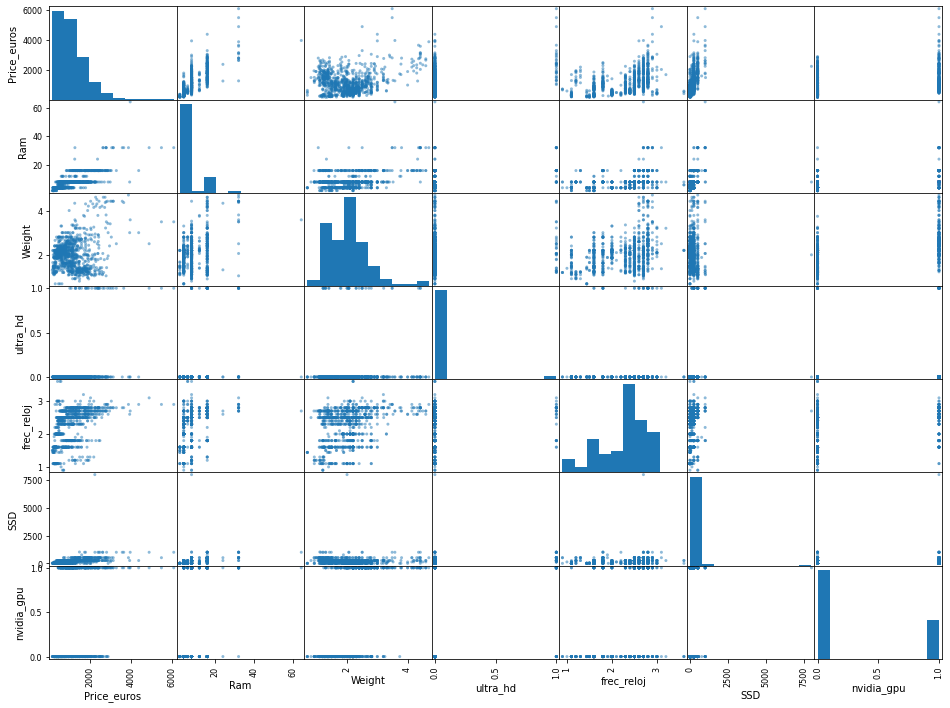

In [15]:
atributos = ["Price_euros", "Ram", "Weight", "ultra_hd", "frec_reloj", "SSD", "nvidia_gpu"]
pd.plotting.scatter_matrix(laptops[atributos], figsize=(16,12)); # Este punto y coma al final impide que se imprima un texto que se genera al ejecutar scatter_matrix

## 4. Preprocesamiento de datos

En este paso, vamos a hacer uso de `pipelines` que nos permitirán preparar los datos para crear modelos de aprendizaje de máquina.

Tenemos dos características de datos, numéricos (Ram, ssd, frecuencia del reloj, etc.)  y categóricos (resolución de pantalla, compañía, fabricante de la gpu, etc.) por lo que es necesario hacer un preprocesamiento distinto para cada uno de estos tipos de datos.

Para los datos categóricos, vamos a hacer uso de la clase `OneHotEncoder` que permite convertir datos categóricos en datos numéricos. Esto creará una columna para cada valor distinto de cada atributo categórico y para cada fila le dará un valor de 1 o 0, similar a como trabajamos con la columna `ScreenResolution`.

Para los datos numéricos, utilizaremos la clase `StandardScaler` para hacer un escalamiento de los valores numéricos.

Aunque este conjunto de datos no contiene valores ausentes, utilizaremos `SimpleImputer` que permite rellenar los valores ausentes con una estrategia especificada (media, mediana, etc.), en este caso utilizaremos la media. 

Por último, implementaremos estos cambios usando `Pipeline`.

In [16]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([("imputer", SimpleImputer(strategy="median")),
                        ("std_scaler", StandardScaler())])

cat_pipeline = Pipeline([("encoder", OneHotEncoder())])

Ahora, combinemos ambas pipelines en una sola utilizando `ColumnTransformer`

In [17]:
from sklearn.compose import ColumnTransformer

atributos_num = ["Inches", "Ram", "Weight", "frec_reloj", "SSD", "HDD", "flash_storage"] # A los cuales se aplicará num_pipeline
atributos_cat = ["Company", "TypeName", "OpSys", "resolution"] # A los cuales se aplicará cat_pipeline

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, atributos_num),
    ("cat", cat_pipeline, atributos_cat)], 
    remainder="passthrough")

laptops_entrena_prep = full_pipeline.fit_transform(laptops_entrena)
laptops_prueba_prep = full_pipeline.transform(laptops_prueba)

## 5. Modelos

### 5.1. _Linear Regression_

In [18]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(laptops_entrena_prep, laptops_entrena_precios)

lin_reg_puntuacion_entren = lin_reg.score(laptops_entrena_prep, laptops_entrena_precios)
lin_reg_puntuacion_prueba = lin_reg.score(laptops_prueba_prep, laptops_prueba_precios)

print("Puntuación en los datos de entrenamiento {}".format(lin_reg_puntuacion_entren))
print("Puntuación en los datos de prueba {}".format(lin_reg_puntuacion_prueba))

Puntuación en los datos de entrenamiento 0.7954247936893584
Puntuación en los datos de prueba -1.6144014882848765e+21


### 5.2. _Decision Tree Regression_

In [20]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(laptops_entrena_prep, laptops_entrena_precios)

tree_reg_puntuacion_entren = tree_reg.score(laptops_entrena_prep, laptops_entrena_precios)
tree_reg_puntuacion_prueba = tree_reg.score(laptops_prueba_prep, laptops_prueba_precios)

print("Puntuación en los datos de entrenamiento {}".format(tree_reg_puntuacion_entren))
print("Puntuación en los datos de prueba {}".format(tree_reg_puntuacion_prueba))

Puntuación en los datos de entrenamiento 0.9978200895160615
Puntuación en los datos de prueba 0.6375168308964005


### 5.3. _Random Forest Regression_

In [21]:
from sklearn.ensemble import RandomForestRegressor

rforest_reg = RandomForestRegressor()
rforest_reg.fit(laptops_entrena_prep, laptops_entrena_precios)

rforest_reg_puntuacion_entren = rforest_reg.score(laptops_entrena_prep, laptops_entrena_precios)
rforest_reg_puntuacion_prueba = rforest_reg.score(laptops_prueba_prep, laptops_prueba_precios)

print("Puntuación en los datos de entrenamiento {}".format(rforest_reg_puntuacion_entren))
print("Puntuación en los datos de prueba {}".format(rforest_reg_puntuacion_prueba))

Puntuación en los datos de entrenamiento 0.9757257410739825
Puntuación en los datos de prueba 0.7929973092334909
